# Sentiment Analysis: Newsfeed of 3 blue chip stocks

This does not look at the correlation against the closing value of each stock and the trade volumes. 

## Notebook Preparation

In [318]:
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
import itertools as it

import matplotlib.pyplot as plt
%matplotlib inline

# Import the hvPlot library
import hvplot.pandas

In [319]:
# Vader Sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

def print_sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(snt)))

## AAPL 30 Day Newsfeed

In [320]:
# Access the CSV and rename the columns
AAPL_news = Path ('AAPL.csv')
AAPL_news_df = pd.read_csv(AAPL_news)
AAPL_news_df.head()
AAPL_news_df1 = AAPL_news_df.rename(columns={'publishedAt': 'Date', 'title': 'Title'})

# Need to convert the date time into dates so it can be sortby
AAPL_news_df1["Date"] = AAPL_news_df1["Date"].str.replace("T", " ", regex=True).str.replace("Z", "", regex=True).astype(str)
AAPL_news_df1['Date'] = pd.to_datetime(AAPL_news_df1['Date']).dt.strftime('%d/%m/%Y')
AAPL_news_df1

,Unnamed: 0,status,totalResults,source,author,Title,description,url,urlToImage,Date,content
0,0,ok,1902,"{'id': 'reuters', 'name': 'Reuters'}",NaN,Epic accuses Apple of 'delaying' key U.S. appe...,Video game maker Epic Games Inc on Wednesday a...,https://www.reuters.com/legal/litigation/epic-...,https://www.reuters.com/resizer/Wn4SAt2CidfgP0...,30/06/2022,<ul><li>\r\nSummary</li><li>\r\nLaw firms</li>...
1,1,ok,1902,"{'id': 'reuters', 'name': 'Reuters'}",NaN,Apple fights NFL Sunday Ticket plaintiffs over...,Apple Inc is fighting to shield its commercial...,https://www.reuters.com/legal/transactional/ap...,https://www.reuters.com/resizer/KT5PL4ZydiQlop...,14/06/2022,(Reuters) - Apple Inc is fighting to shield it...
2,2,ok,1902,"{'id': 'reuters', 'name': 'Reuters'}",Reuters Editorial,Apple store workers in Maryland form first US ...,19/06 Apple Inc AAPL.O workers in Maryland vot...,https://www.reuters.com/video/watch/idsKTY?now...,https://ajo.prod.reuters.tv/api/v2/img/62aed12...,19/06/2022,Posted \r\n19/06 Apple Inc AAPL.O workers in M...
3,3,ok,1902,"{'id': 'reuters', 'name': 'Reuters'}",NaN,"Enjoy Technology, led by ex-Apple and JC Penne...","Enjoy Technology Inc <a href=""https://www.reut...",https://www.reuters.com/technology/enjoy-techn...,https://www.reuters.com/resizer/OJYKRXTcuzrRcC...,30/06/2022,June 30 (Reuters) - Enjoy Technology Inc (ENJY...
4,4,ok,1902,"{'id': 'reuters', 'name': 'Reuters'}",NaN,Adobe revamps metaverse design tools for Apple...,"Adobe Inc <a href=""https://www.reuters.com/com...",https://www.reuters.com/technology/adobe-revam...,https://www.reuters.com/resizer/BUiuAcEADOE8GV...,14/06/2022,June 14 (Reuters) - Adobe Inc (ADBE.O) on Tues...
...,...,...,...,...,...,...,...,...,...,...,...
95,95,ok,1902,"{'id': None, 'name': 'HYPEBEAST'}","info@hypebeast.com (HYPEBEAST), HYPEBEAST",Apple’s Mixed Reality Headset Will Reportedly ...,Apple’s rumored mixed reality headset has been...,https://hypebeast.com/2022/6/apple-mixed-reali...,https://image-cdn.hypb.st/https%3A%2F%2Fhypebe...,27/06/2022,Apples rumored mixed reality headset has been ...
96,96,ok,1902,"{'id': None, 'name': 'Techmeme.com'}",NaN,"Apple's CarPlay update, demoed at WWDC, lets u...",Stephen Nellis / Reuters:\nApple's CarPlay upd...,https://www.techmeme.com/220630/p24,https://www.reuters.com/resizer/qBxnnsIEK0H3LM...,30/06/2022,The New Consumer— by Dan Frommer\r\nA publicat...
97,97,ok,1902,"{'id': None, 'name': 'MarketWatch'}",Philip van Doorn,Deep Dive: Here’s the best way to play the S&P...,These 10 Dividend Aristocrats delivered excell...,https://www.marketwatch.com/story/heres-the-be...,https://images.mktw.net/im-577259/social,06/07/2022,Stocks with attractive dividend yields have re...
98,98,ok,1902,"{'id': None, 'name': 'Imapenguin.com'}",Michael Doornbos,How fast can a 6502 transfer memory,The amazing Gregorio Naçu posted the article t...,https://imapenguin.com/how-fast-can-a-6502-tra...,https://imapenguin.com/content/images/2022/06/...,16/06/2022,The amazing Gregorio Naçu posted the article t...


In [321]:
# Remove irrelevant columns and set the 'publishedAt' as the index
AAPL_news_df1.set_index(pd.to_datetime(AAPL_news_df1['Date'], infer_datetime_format=True), inplace=True)
AAPL_news_df1.drop(columns=['Date', 'status', 'Unnamed: 0', 'totalResults', 'source', 'author', 'url', 'urlToImage', 'description', 'content'], inplace=True)
AAPL_news_df1

,Title
Date,
2022-06-30,Epic accuses Apple of 'delaying' key U.S. appe...
2022-06-14,Apple fights NFL Sunday Ticket plaintiffs over...
2022-06-19,Apple store workers in Maryland form first US ...
2022-06-30,"Enjoy Technology, led by ex-Apple and JC Penne..."
2022-06-14,Adobe revamps metaverse design tools for Apple...
...,...
2022-06-27,Apple’s Mixed Reality Headset Will Reportedly ...
2022-06-30,"Apple's CarPlay update, demoed at WWDC, lets u..."
2022-07-06,Deep Dive: Here’s the best way to play the S&P...


### Sentiment Analysis: AAPL

In [322]:
AAPL_news_df1['Neg'] = AAPL_news_df1['Title'].apply(lambda x:analyser.polarity_scores(x)['neg'])
AAPL_news_df1['Neu'] = AAPL_news_df1['Title'].apply(lambda x:analyser.polarity_scores(x)['neu'])
AAPL_news_df1['Pos'] = AAPL_news_df1['Title'].apply(lambda x:analyser.polarity_scores(x)['pos'])
AAPL_news_df1['Compound'] = AAPL_news_df1['Title'].apply(lambda x:analyser.polarity_scores(x)['compound'])

AAPL_news_df1

,Title,Neg,Neu,Pos,Compound
Date,,,,,
2022-06-30,Epic accuses Apple of 'delaying' key U.S. appe...,0.179,0.821,0.000,-0.3400
2022-06-14,Apple fights NFL Sunday Ticket plaintiffs over...,0.213,0.787,0.000,-0.4019
2022-06-19,Apple store workers in Maryland form first US ...,0.000,1.000,0.000,0.0000
2022-06-30,"Enjoy Technology, led by ex-Apple and JC Penne...",0.000,0.802,0.198,0.4939
2022-06-14,Adobe revamps metaverse design tools for Apple...,0.000,1.000,0.000,0.0000
...,...,...,...,...,...
2022-06-27,Apple’s Mixed Reality Headset Will Reportedly ...,0.000,0.887,0.113,0.1027
2022-06-30,"Apple's CarPlay update, demoed at WWDC, lets u...",0.000,1.000,0.000,0.0000
2022-07-06,Deep Dive: Here’s the best way to play the S&P...,0.000,0.625,0.375,0.7650


In [323]:
# Groupby index (date)
AAPL_news_df_grp = AAPL_news_df1.groupby('Date')['Compound'].describe()
AAPL_news_df_grp

,count,mean,std,min,25%,50%,75%,max
Date,,,,,,,,
2022-06-07,5.0,0.171100,0.382591,0.0000,0.000000,0.00000,0.000000,0.8555
2022-06-08,3.0,0.001200,0.307838,-0.3182,-0.146200,0.02580,0.160900,0.2960
2022-06-09,5.0,0.143680,0.321278,0.0000,0.000000,0.00000,0.000000,0.7184
2022-06-10,8.0,0.078637,0.325078,-0.3818,-0.025675,0.00000,0.119175,0.6369
2022-06-11,4.0,-0.312425,0.272560,-0.6597,-0.419925,-0.29500,-0.187500,0.0000
2022-06-12,1.0,-0.381800,NaN,-0.3818,-0.381800,-0.38180,-0.381800,-0.3818
2022-06-13,2.0,-0.076550,0.108258,-0.1531,-0.114825,-0.07655,-0.038275,0.0000
2022-06-14,6.0,0.150850,0.428942,-0.4019,0.000000,0.00000,0.382950,0.7964
2022-06-15,2.0,0.327100,0.462589,0.0000,0.163550,0.32710,0.490650,0.6542


In [324]:
# Drop columns to create a better plot
AAPL_news_df_grp.drop(columns=['std','min','25%','50%','75%','max'], inplace=True)

#### Total mentions on Newsfeed for 30 days

<AxesSubplot:xlabel='Date'>

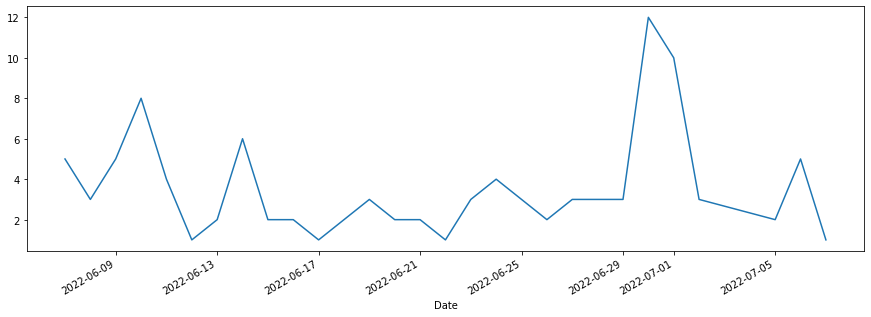

In [325]:
# Plot the total count for newsfeed for the month
AAPL_news_df_grp['count'].plot(figsize=(15,5))

#### Sentiment Analysis: Compound Mean

<AxesSubplot:xlabel='Date'>

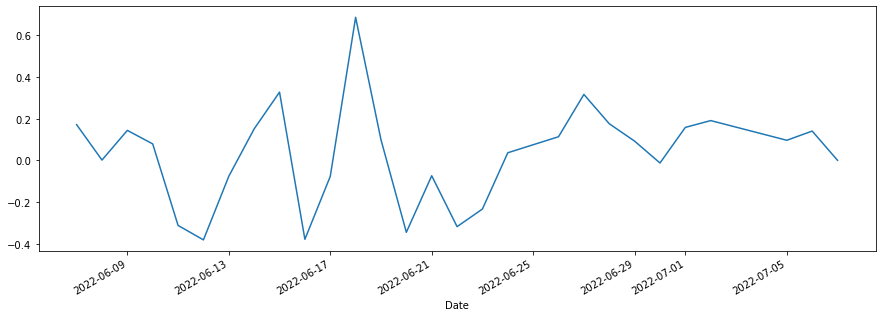

In [326]:
# Plot the mean for Compound Sentiment Analysis
AAPL_news_df_grp['mean'].plot(figsize=(15,5))

#### Sentiment vs Count

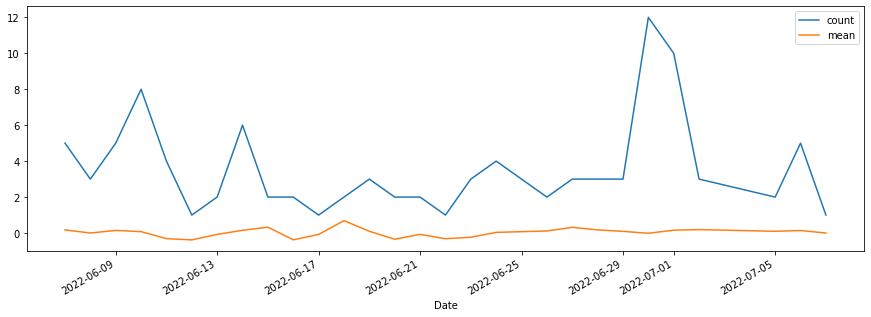

In [327]:
#Using pandas library
AAPL_news_df_grp.plot(figsize=(15,5))
plt.savefig('AAPL_Sentiment_Count.png')

#### Sentiment Analysis: Alternate charts with hvplot

In [328]:
AAPL_news_df_grp.hvplot(
    x='Date',
    y='mean',
    xlabel='Previous 30-Days',
    ylabel='Sentiment Analysis',
    rot=45)

:Curve   [Date]   (mean)

In [329]:
AAPL_news_df_grp.hvplot.bar(
    x='Date',
    y='count',
    xlabel='Previous 30-Days',
    ylabel='Sentiment Analysis',
    rot=45)

:Bars   [Date]   (count)

## AMJ 30 Day Newsfeed

In [330]:
# Access the CSV and rename the columns
AMJ_news = Path ('AMJ.csv')
AMJ_news_df = pd.read_csv(AMJ_news)
AMJ_news_df.head()
AMJ_news_df1 = AMJ_news_df.rename(columns={'publishedAt': 'Date', 'title': 'Title'})

# Need to convert the date time into dates so it can be sortby
AMJ_news_df1["Date"] = AMJ_news_df1["Date"].str.replace("T", " ", regex=True).str.replace("Z", "", regex=True).astype(str)
AMJ_news_df1['Date'] = pd.to_datetime(AMJ_news_df1['Date']).dt.strftime('%d/%m/%Y')
AMJ_news_df1.head()

,Unnamed: 0,status,totalResults,source,author,Title,description,url,urlToImage,Date,content
0,0,ok,847,"{'id': 'reuters', 'name': 'Reuters'}",NaN,JP Morgan wins $1.7 bln Nigeria oil trial in B...,"JP Morgan Chase <a href=""https://www.reuters.c...",https://www.reuters.com/business/jp-morgan-win...,https://www.reuters.com/resizer/6VnhIqdYsGM4IL...,14/06/2022,"LONDON, June 14 (Reuters) - JP Morgan Chase (J..."
1,1,ok,847,"{'id': 'reuters', 'name': 'Reuters'}",NaN,JP Morgan sees portfolio rebalancing lifting U...,U.S. equities could see a 7% move up next week...,https://www.reuters.com/markets/europe/jp-morg...,https://www.reuters.com/resizer/8a651LsLAMy2wV...,24/06/2022,"NEW YORK, June 24 (Reuters) - U.S. equities co..."
2,2,ok,847,"{'id': 'reuters', 'name': 'Reuters'}",NaN,Credit Suisse reinforces UK investment banking...,Switzerland's second-largest bank Credit Suiss...,https://www.reuters.com/business/finance/credi...,https://www.reuters.com/resizer/j1pDWlfZAncCKU...,15/06/2022,"LONDON, June 15 (Reuters) - Switzerland's seco..."
3,3,ok,847,"{'id': None, 'name': 'MacRumors'}",Tim Hardwick,Apple Music and Apple Arcade to Earn $8.2 Bill...,Apple's revenue from its music and gaming subs...,https://www.macrumors.com/2022/06/14/apple-mus...,https://images.macrumors.com/t/FhOW85qUG3EZBw6...,14/06/2022,Apple's revenue from its music and gaming subs...
4,4,ok,847,"{'id': 'bbc-news', 'name': 'BBC News'}",https://www.facebook.com/bbcnews,Roe v Wade: US firms pledge to pay staff trave...,"Disney, JP Morgan and Meta are among the compa...",https://www.bbc.co.uk/news/business-61941591,https://ichef.bbci.co.uk/news/1024/branded_new...,26/06/2022,"Major companies including Disney, JP Morgan an..."
...,...,...,...,...,...,...,...,...,...,...,...
95,95,ok,847,"{'id': None, 'name': 'Yahoo Entertainment'}",Heather Bell,BondBloxx Adds Emerging Market Bond ETF,The issuer focuses on fixed income products.,https://finance.yahoo.com/news/bondbloxx-adds-...,https://s.yimg.com/uu/api/res/1.2/RcnDUaHhXIQo...,30/06/2022,"BondBloxx Investment Management, a new issuer ..."
96,96,ok,847,"{'id': None, 'name': 'Seeking Alpha'}",Retired Investor,QUAL Vs. JQUA For Quality-Factor ETF Title,QUAL is the iShares MSCI USA Quality Factor ET...,https://seekingalpha.com/article/4516376-qual-...,https://static.seekingalpha.com/cdn/s3/uploads...,08/06/2022,gesrey/iStock via Getty Images\r\n(This articl...
97,97,ok,847,"{'id': None, 'name': 'Yahoo Entertainment'}",ACCESSWIRE,Charge Enterprises to Present at the J.P. Morg...,"NEW YORK, NY / ACCESSWIRE / June 16, 2022 /Cha...",https://finance.yahoo.com/news/charge-enterpri...,https://s.yimg.com/cv/apiv2/social/images/yaho...,16/06/2022,"NEW YORK, NY / ACCESSWIRE / June 16, 2022 /Cha..."
98,98,ok,847,"{'id': None, 'name': 'The Advocate'}",NaN,"New hires at The Water Institute, Breazeale, S...","New hires at The Water Institute, Breazeale, S...",https://www.theadvocate.com/baton_rouge/news/b...,https://bloximages.newyork1.vip.townnews.com/t...,26/06/2022,Baton Rouge\r\nJessica Renee Henkel has joined...


In [331]:
# Remove irrelevant columns and set the 'publishedAt' as the index
AMJ_news_df1.set_index(pd.to_datetime(AMJ_news_df1['Date'], infer_datetime_format=True), inplace=True)
AMJ_news_df1.drop(columns=['Date', 'status', 'Unnamed: 0', 'totalResults', 'source', 'author', 'url', 'urlToImage', 'description', 'content'], inplace=True)
AMJ_news_df1

,Title
Date,
2022-06-14,JP Morgan wins $1.7 bln Nigeria oil trial in B...
2022-06-24,JP Morgan sees portfolio rebalancing lifting U...
2022-06-15,Credit Suisse reinforces UK investment banking...
2022-06-14,Apple Music and Apple Arcade to Earn $8.2 Bill...
2022-06-26,Roe v Wade: US firms pledge to pay staff trave...
...,...
2022-06-30,BondBloxx Adds Emerging Market Bond ETF
2022-06-08,QUAL Vs. JQUA For Quality-Factor ETF Title
2022-06-16,Charge Enterprises to Present at the J.P. Morg...


### Sentiment Analysis: AMJ

In [332]:
AMJ_news_df1['Neg'] = AMJ_news_df1['Title'].apply(lambda x:analyser.polarity_scores(x)['neg'])
AMJ_news_df1['Neu'] = AMJ_news_df1['Title'].apply(lambda x:analyser.polarity_scores(x)['neu'])
AMJ_news_df1['Pos'] = AMJ_news_df1['Title'].apply(lambda x:analyser.polarity_scores(x)['pos'])
AMJ_news_df1['Compound'] = AMJ_news_df1['Title'].apply(lambda x:analyser.polarity_scores(x)['compound'])
AMJ_news_df1

,Title,Neg,Neu,Pos,Compound
Date,,,,,
2022-06-14,JP Morgan wins $1.7 bln Nigeria oil trial in B...,0.000,0.616,0.384,0.7378
2022-06-24,JP Morgan sees portfolio rebalancing lifting U...,0.000,0.826,0.174,0.3680
2022-06-15,Credit Suisse reinforces UK investment banking...,0.000,0.822,0.178,0.3818
2022-06-14,Apple Music and Apple Arcade to Earn $8.2 Bill...,0.000,0.863,0.137,0.3680
2022-06-26,Roe v Wade: US firms pledge to pay staff trave...,0.104,0.896,0.000,-0.1027
...,...,...,...,...,...
2022-06-30,BondBloxx Adds Emerging Market Bond ETF,0.000,1.000,0.000,0.0000
2022-06-08,QUAL Vs. JQUA For Quality-Factor ETF Title,0.000,1.000,0.000,0.0000
2022-06-16,Charge Enterprises to Present at the J.P. Morg...,0.000,0.840,0.160,0.2732


In [333]:
# Groupby index (date)
AMJ_news_df_grp = AMJ_news_df1.groupby('Date')['Compound'].describe()
AMJ_news_df_grp

,count,mean,std,min,25%,50%,75%,max
Date,,,,,,,,
2022-06-07,2.0,0.028500,0.849094,-0.5719,-0.271700,0.02850,0.328700,0.6289
2022-06-08,8.0,-0.047613,0.218485,-0.5574,-0.006450,0.00000,0.000000,0.2023
2022-06-09,5.0,-0.059200,0.132375,-0.2960,0.000000,0.00000,0.000000,0.0000
2022-06-13,4.0,0.239850,0.164521,0.0000,0.204900,0.29570,0.330650,0.3680
2022-06-14,11.0,0.250427,0.222764,0.0000,0.042850,0.27320,0.368000,0.7378
2022-06-15,7.0,0.256257,0.377753,-0.3818,0.025800,0.38180,0.541250,0.6597
2022-06-16,7.0,-0.015357,0.366502,-0.7269,-0.051350,0.00000,0.140850,0.4404
2022-06-17,6.0,-0.030650,0.307144,-0.3818,-0.222000,0.00000,0.000000,0.4939
2022-06-18,1.0,0.756900,NaN,0.7569,0.756900,0.75690,0.756900,0.7569


In [334]:
# Drop columns to create a better plot
AMJ_news_df_grp.drop(columns=['std','min','25%','50%','75%','max'], inplace=True)

#### Total mentions on Newsfeed for 30 days

<AxesSubplot:xlabel='Date'>

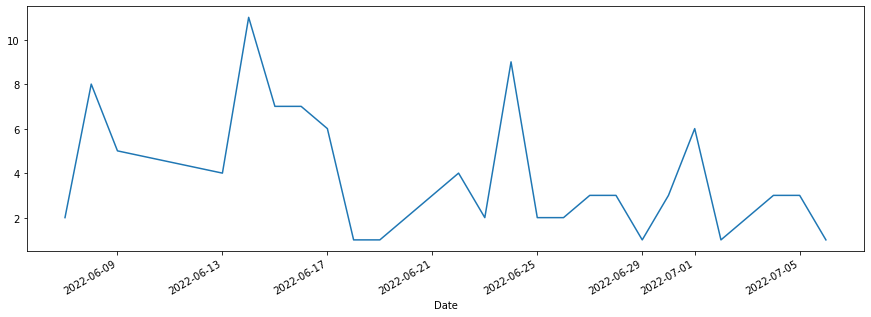

In [335]:
# Plot the total count for newsfeed for the month
AMJ_news_df_grp['count'].plot(figsize=(15,5))

#### Sentiment Analysis: Compound Mean

<AxesSubplot:xlabel='Date'>

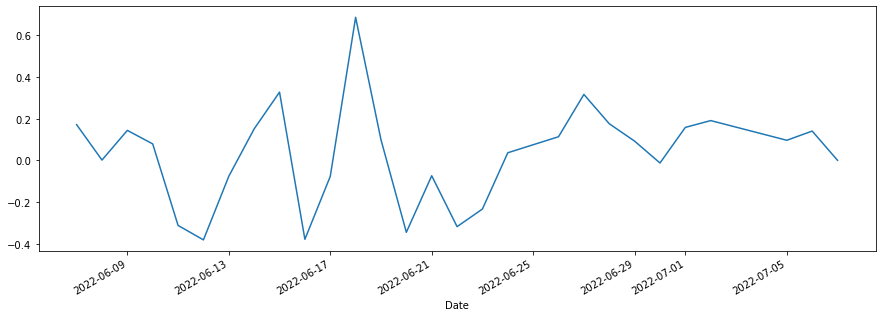

In [336]:
# Plot the mean for Compound Sentiment Analysis
AAPL_news_df_grp['mean'].plot(figsize=(15,5))

#### Sentiment vs Count

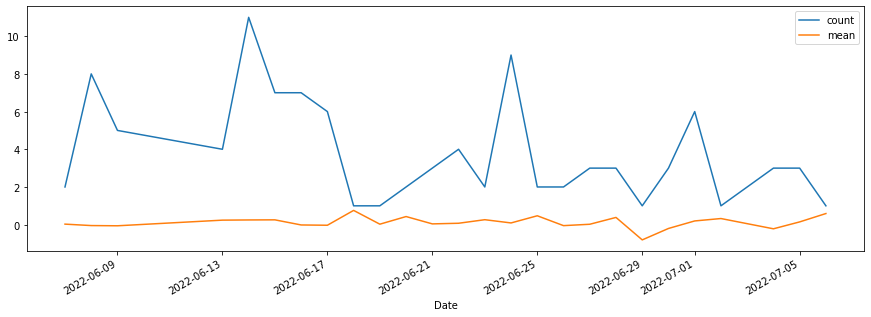

In [337]:
#Using pandas library
AMJ_news_df_grp.plot(figsize=(15,5))
plt.savefig('AMJ_Sentiment_Count.png')

#### Sentiment Analysis: Alternate charts with hvplot

In [338]:
AMJ_news_df_grp.hvplot(
    x='Date',
    y='mean',
    xlabel='Previous 30-Days',
    ylabel='Sentiment Analysis',
    rot=45)

:Curve   [Date]   (mean)

In [339]:
AMJ_news_df_grp.hvplot.bar(
    x='Date',
    y='count',
    xlabel='Previous 30-Days',
    ylabel='Sentiment Analysis',
    rot=45)

:Bars   [Date]   (count)

## JLL 30 Day Newsfeed

In [340]:
# Access the CSV and rename the columns
JLL_news = Path ('JLL.csv')
JLL_news_df = pd.read_csv(JLL_news)
JLL_news_df.head()
JLL_news_df1 = JLL_news_df.rename(columns={'publishedAt': 'Date', 'title': 'Title'})

# Need to convert the date time into dates so it can be sortby
JLL_news_df1["Date"] = JLL_news_df1["Date"].str.replace("T", " ", regex=True).str.replace("Z", "", regex=True).astype(str)
JLL_news_df1['Date'] = pd.to_datetime(JLL_news_df1['Date']).dt.strftime('%d/%m/%Y')
JLL_news_df1.head()

,Unnamed: 0,status,totalResults,source,author,Title,description,url,urlToImage,Date,content
0,0,ok,48,"{'id': None, 'name': 'Los Angeles Business Jou...",NaN,Development Sites Sell for $47M - Los Angeles ...,Learn about a nearly $47 million sale of two s...,https://labusinessjournal.com/real-estate/deve...,https://d3evu7qlt2vui6.cloudfront.net/wp-conte...,20/06/2022,Two parcels on the border of West Hollywood an...
1,1,ok,48,"{'id': None, 'name': 'Planetizen.com'}",Diana Ionescu,A New Life for the Suburban Office Park?,A New Life for the Suburban Office Park?\nDian...,https://www.planetizen.com/news/2022/07/117693...,https://www.planetizen.com/files/images/shutte...,06/07/2022,"Writing in The New York Times, Emily Badger de..."
2,2,ok,48,"{'id': None, 'name': 'Dailyinfographic.com'}",Lyle Opolentisima,The 10 Most Valuable Sports Empires. Defined B...,"When we talk about sports, it’s obvious that w...",https://dailyinfographic.com/the-most-valuable...,https://dailyinfographic.com/wp-content/upload...,19/06/2022,"When we talk about sports, it’s obvious that w..."
3,3,ok,48,"{'id': None, 'name': 'Www.rfi.fr'}",RFI,"Warehouse business catches fire, boosted by pa...",The rise of e-commerce and the logistical nigh...,https://www.rfi.fr/en/warehouse-business-catch...,https://s.rfi.fr/media/display/6ff0737c-ef72-1...,19/06/2022,New York (AFP) The rise of e-commerce and the ...
4,4,ok,48,"{'id': None, 'name': 'Los Angeles Business Jou...",NaN,LVMH's luxury hotel project approved - Los Ang...,The long-awaited Cheval Blanc Beverly Hills ho...,https://labusinessjournal.com/featured/lvmhs-l...,https://d3evu7qlt2vui6.cloudfront.net/wp-conte...,27/06/2022,The long-awaited Cheval Blanc Beverly Hills ho...


In [341]:
# Remove irrelevant columns and set the 'publishedAt' as the index
JLL_news_df1.set_index(pd.to_datetime(JLL_news_df1['Date'], infer_datetime_format=True), inplace=True)
JLL_news_df1.drop(columns=['Date', 'status', 'Unnamed: 0', 'totalResults', 'source', 'author', 'url', 'urlToImage', 'description', 'content'], inplace=True)
JLL_news_df1.head()

,Title
Date,
2022-06-20,Development Sites Sell for $47M - Los Angeles ...
2022-07-06,A New Life for the Suburban Office Park?
2022-06-19,The 10 Most Valuable Sports Empires. Defined B...
2022-06-19,"Warehouse business catches fire, boosted by pa..."
2022-06-27,LVMH's luxury hotel project approved - Los Ang...


### Sentiment Analysis: JLL

In [342]:
JLL_news_df1['Neg'] = JLL_news_df1['Title'].apply(lambda x:analyser.polarity_scores(x)['neg'])
JLL_news_df1['Neu'] = JLL_news_df1['Title'].apply(lambda x:analyser.polarity_scores(x)['neu'])
JLL_news_df1['Pos'] = JLL_news_df1['Title'].apply(lambda x:analyser.polarity_scores(x)['pos'])
JLL_news_df1['Compound'] = JLL_news_df1['Title'].apply(lambda x:analyser.polarity_scores(x)['compound'])
JLL_news_df1.head()

,Title,Neg,Neu,Pos,Compound
Date,,,,,
2022-06-20,Development Sites Sell for $47M - Los Angeles ...,0.000,1.000,0.000,0.0000
2022-07-06,A New Life for the Suburban Office Park?,0.000,1.000,0.000,0.0000
2022-06-19,The 10 Most Valuable Sports Empires. Defined B...,0.000,0.793,0.207,0.5256
2022-06-19,"Warehouse business catches fire, boosted by pa...",0.173,0.647,0.180,0.0258
2022-06-27,LVMH's luxury hotel project approved - Los Ang...,0.000,0.763,0.237,0.4215


In [343]:
# Groupby index (date)
JLL_news_df_grp = JLL_news_df1.groupby('Date')['Compound'].describe()
JLL_news_df_grp

,count,mean,std,min,25%,50%,75%,max
Date,,,,,,,,
2022-06-08,1.0,0.000000,NaN,0.0000,0.000000,0.00000,0.000000,0.0000
2022-06-09,1.0,0.421500,NaN,0.4215,0.421500,0.42150,0.421500,0.4215
2022-06-10,1.0,0.000000,NaN,0.0000,0.000000,0.00000,0.000000,0.0000
2022-06-15,2.0,0.220200,0.311410,0.0000,0.110100,0.22020,0.330300,0.4404
2022-06-16,1.0,0.624900,NaN,0.6249,0.624900,0.62490,0.624900,0.6249
2022-06-17,2.0,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.0000
2022-06-18,1.0,0.000000,NaN,0.0000,0.000000,0.00000,0.000000,0.0000
2022-06-19,3.0,0.192400,0.288560,0.0258,0.025800,0.02580,0.275700,0.5256
2022-06-20,2.0,-0.299700,0.423840,-0.5994,-0.449550,-0.29970,-0.149850,0.0000


In [344]:
# Drop columns to create a better plot
JLL_news_df_grp.drop(columns=['std','min','25%','50%','75%','max'], inplace=True)

#### Total mentions on Newsfeed for 30 days

<AxesSubplot:xlabel='Date'>

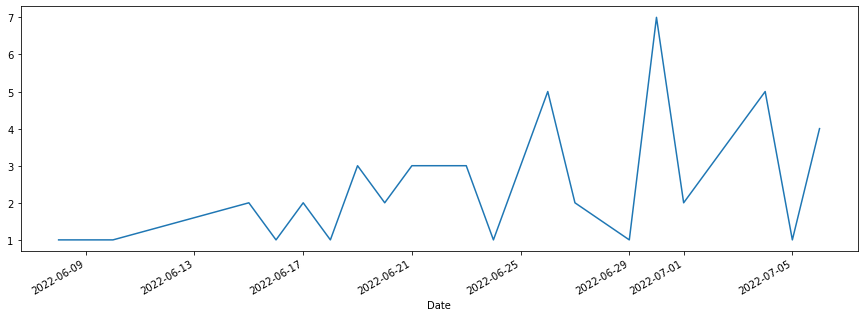

In [345]:
# Plot the total count for newsfeed for the month
JLL_news_df_grp['count'].plot(figsize=(15,5))

#### Sentiment Analysis: Compound Mean

<AxesSubplot:xlabel='Date'>

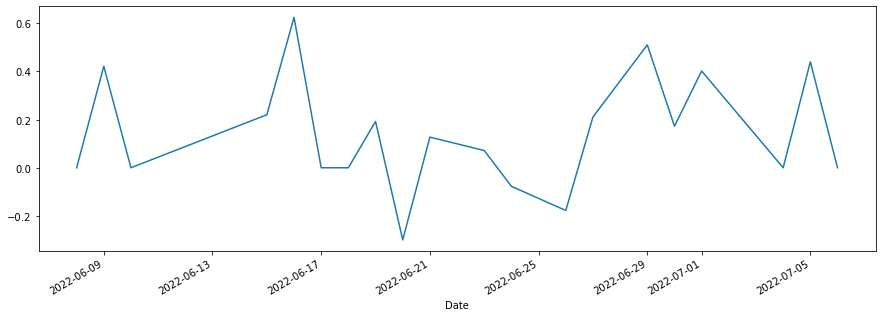

In [346]:
# Plot the mean for Compound Sentiment Analysis
JLL_news_df_grp['mean'].plot(figsize=(15,5))

#### Sentiment vs Count

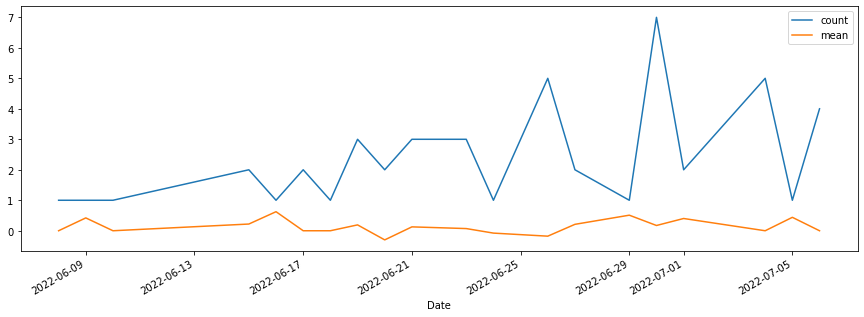

In [347]:
#Using pandas library
JLL_news_df_grp.plot(figsize=(15,5))
plt.savefig('JLL_Sentiment_Count.png')

#### Sentiment Analysis: Alternate charts with hvplot

In [348]:
JLL_news_df_grp.hvplot(
    x='Date',
    y='mean',
    xlabel='Previous 30-Days',
    ylabel='Sentiment Analysis',
    rot=45)

:Curve   [Date]   (mean)

In [349]:
JLL_news_df_grp.hvplot.bar(
    x='Date',
    y='count',
    xlabel='Previous 30-Days',
    ylabel='Sentiment Analysis',
    rot=45)

:Bars   [Date]   (count)